In [7]:
from ConfigSpace import Configuration, ConfigurationSpace

import numpy as np
from smac import HyperparameterOptimizationFacade, Scenario
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

iris = datasets.load_iris()


def train(config: Configuration, seed: int = 0) -> float:
    classifier = SVC(C=config["C"], random_state=seed)
    scores = cross_val_score(classifier, iris.data, iris.target, cv=5)
    return 1 - np.mean(scores)


configspace = ConfigurationSpace({"C": (0.100, 1000.0)})

# Scenario object specifying the optimization environment
scenario = Scenario(configspace, deterministic=True, n_trials=200)

# Use SMAC to find the best configuration/hyperparameters
smac = HyperparameterOptimizationFacade(scenario, train)
incumbent = smac.optimize()

[INFO][abstract_initial_design.py:139] Using 10 initial design configurations and 0 additional configurations.
[INFO][smbo.py:509] Continuing from previous run.
[INFO][smbo.py:278] Optimization process was already finished. Returning incumbent...


In [5]:
incumbent

Configuration(values={
  'C': 6.5997719891441,
})

[INFO][abstract_initial_design.py:139] Using 10 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:307] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:517] Added config e08add as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:596] Added config e86960 and rejected config e08add as incumbent because it is not better than the incumbents on 1 instances: 
[INFO][abstract_intensifier.py:596] Added config 78cf4a and rejected config e86960 as incumbent because it is not better than the incumbents on 1 instances: 
[INFO][abstract_intensifier.py:596] Added config 9c0078 and rejected config 78cf4a as incumbent because it is not better than the incumbents on 1 instances: 
[INFO][abstract_intensifier.py:596] Added config 468dc7 and rejected config 9c0078 as incumbent because it is not better than the incumbents on 1 instances: 
[INFO][abstract_intensifier.py:596] Added config 124616 and rej

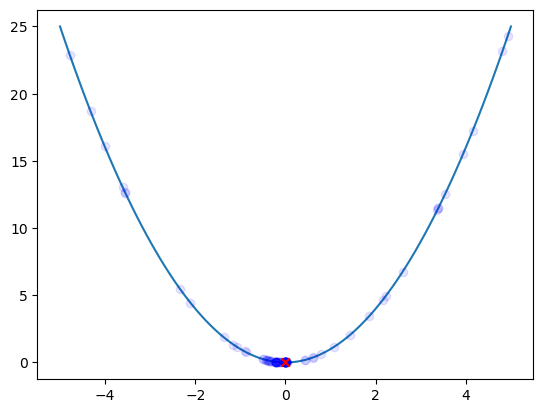

In [9]:
import numpy as np
from ConfigSpace import Configuration, ConfigurationSpace, Float
from matplotlib import pyplot as plt

from smac.facade.hyperparameter_optimization_facade import HyperparameterOptimizationFacade as HPOFacade
from smac import RunHistory, Scenario

__copyright__ = "Copyright 2025, Leibniz University Hanover, Institute of AI"
__license__ = "3-clause BSD"


class QuadraticFunction:
    @property
    def configspace(self) -> ConfigurationSpace:
        cs = ConfigurationSpace(seed=0)
        x = Float("x", (-5, 5), default=-5)
        cs.add([x])

        return cs

    def train(self, config: Configuration, seed: int = 0) -> float:
        """Returns the y value of a quadratic function with a minimum we know to be at x=0."""
        x = config["x"]
        return x**2


def plot(runhistory: RunHistory, incumbent: Configuration) -> None:
    plt.figure()

    # Plot ground truth
    x = list(np.linspace(-5, 5, 100))
    y = [xi * xi for xi in x]
    plt.plot(x, y)

    # Plot all trials
    for k, v in runhistory.items():
        config = runhistory.get_config(k.config_id)
        x = config["x"]
        y = v.cost  # type: ignore
        plt.scatter(x, y, c="blue", alpha=0.1, zorder=9999, marker="o")

    # Plot incumbent
    plt.scatter(incumbent["x"], incumbent["x"] * incumbent["x"], c="red", zorder=10000, marker="x")

    plt.show()


if __name__ == "__main__":
    model = QuadraticFunction()

    # Scenario object specifying the optimization "environment"
    scenario = Scenario(model.configspace, deterministic=True, n_trials=100)

    # Now we use SMAC to find the best hyperparameters
    smac = HPOFacade(
        scenario,
        model.train,  # We pass the target function here
        overwrite=True,  # Overrides any previous results that are found that are inconsistent with the meta-data
    )

    incumbent = smac.optimize()

    # Get cost of default configuration
    default_cost = smac.validate(model.configspace.get_default_configuration())
    print(f"Default cost: {default_cost}")

    # Let's calculate the cost of the incumbent
    incumbent_cost = smac.validate(incumbent)
    print(f"Incumbent cost: {incumbent_cost}")

    # Let's plot it too
    plot(smac.runhistory, incumbent)